In [20]:
sys.path.append(r'C:\users\dolga\appdata\local\programs\python\python37\lib\site-packages')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
import skimage.transform
import PIL
import imageio
from IPython.display import clear_output
import sys
import sys
import numpy as np
import cv2 as cv


In [107]:
def process(dataset_path):
    data = []

    for image in sorted(Path(dataset_path).iterdir()):        
        item = {}
        img = io.imread(image,plugin='matplotlib')
#         print(img.shape)
        
        img1 = cv.imread(dataset_path+image.name)
        gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
#         print(gray.shape)
        binary = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,13,22)
        img.reshape(24,24,1)
#         print(img1.shape)
        res = np.concatenate((binary.reshape(24,24,1),img1),axis=2)
#         print(res.shape)
        item[0] = int(image.name.split('.')[0])
        item[1] = t.from_numpy(res)
        data.append(item)
    return data
# test = process('t/images/')
# t.save(test, TEST_PATH)
train_data = process('EyesDataset/EyesDataset/')
dev_data = process('dev/')
# test_deta = process('test/')

In [108]:
len(train_data)

3883

In [109]:
image_size = 24

In [110]:
class Dataset():
    def __init__(self, data, source_transform):
        self.datas = data
        self.s_transform = source_transform
#         self.t_transform = target_transform
    def __getitem__(self, index):
#         print(index)
        data = self.datas[index]
        img = np.array(data[1])
#         print(img.shape)
#         mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
#         mask = self.t_transform(mask)
        return img
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((image_size, image_size)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5],std = [0.5])
]
)
dataset = Dataset(train_data,s_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

In [112]:
# img = dataset[0]
# # plt.subplot(12)
# plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5, cmap = 'gray')

In [113]:
dataset_dev = Dataset(dev_data,s_trans)

In [115]:
# dataset_test = Dataset(test_deta,s_trans)

In [116]:
BATCH_SIZE = 50

In [117]:
train_loader = t.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [118]:
dev_loader = t.utils.data.DataLoader(dataset_dev)

In [119]:
len(dev_loader)

40

In [120]:
import torch
import torch.nn as nn
from torch.autograd import Variable


In [121]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(4, 16, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, 3, stride=2, padding=3, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [122]:
# dataset[:10]

In [123]:
autoencoder = AutoEncoder()
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
loss_func = nn.MSELoss()

# original data (first row) for viewing
view_data = Variable(dataset[0].view(-1, image_size*image_size).type(torch.FloatTensor)/255.)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [124]:
len(dataset)

3883

In [125]:
EPOCH = 100

In [126]:
loss_ = []

In [127]:
for epoch in range(EPOCH):
    for step, (x) in enumerate(train_loader):
        img = x
#         img = img.to(device)
#         img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        encoded, decoded = autoencoder(img)
#         print(encoded.shape)
        loss = loss_func(decoded, img)
        loss.backward()
        optimizer.step()
#         print(loss.data)
        loss_.append(loss)
        if epoch in [0, 5,10,20,30,40,50,60,70,80,90, EPOCH-1] and step==0:
            print(epoch,'____________________________________',loss.data)
#             

0 ____________________________________ tensor(0.4512)
5 ____________________________________ tensor(0.1315)
10 ____________________________________ tensor(0.1134)
20 ____________________________________ tensor(0.1222)
30 ____________________________________ tensor(0.1363)
40 ____________________________________ tensor(0.0949)
50 ____________________________________ tensor(0.1068)
60 ____________________________________ tensor(0.1137)
70 ____________________________________ tensor(0.0959)
80 ____________________________________ tensor(0.1043)
90 ____________________________________ tensor(0.0949)
99 ____________________________________ tensor(0.1113)


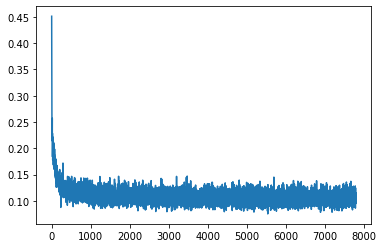

In [128]:
plt.plot(loss_)

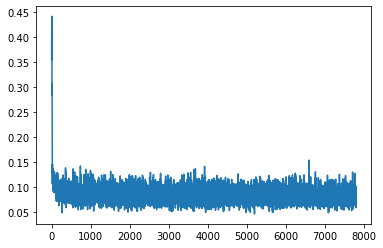

In [73]:
plt.plot(loss_)

In [129]:
len(train_loader)

78

In [130]:
i = 0
# res = None
for x in enumerate(train_loader):
    img = x[1]
    print(x[1].shape)
#     img = img.view(img.size(0), -1)
#     print(img.shape)
    encoded, decoded = autoencoder(img)
    print(encoded.shape)
    
    if i == 0:
        res = encoded.detach().numpy()
    else:
        res = np.vstack((res,encoded.detach().numpy()))
    print(res.shape)
    i+=1

torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(50, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(100, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(150, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(200, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(250, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(300, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(350, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(400, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(450, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(500, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(550, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(600, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(650, 64, 1, 1)
torch.Size([50, 4, 24, 24])
torch.Size([50, 64, 1, 1])
(700, 64, 1, 1)
torch.S

In [325]:
i = 0
for x in enumerate(train_loader):
    img = x[1]
    print(x[1].shape)
    img = img.view(img.size(0), -1)
    encoded, decoded = autoencoder(img)
    print(encoded.shape)
    print(res.shape)
    if i == 0:
        res = encoded.detach().numpy()
    else:
        res = np.vstack((res,encoded.detach().numpy()))
    i+=1
#     print(encoded.detach().numpy()[0])

torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(78, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(50, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(100, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(150, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(200, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(250, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(300, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(350, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(400, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(450, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(500, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(550, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(600, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(650, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(700, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(750, 32)
torch.Size([50, 1, 28, 28])
torch.Size([50, 32])
(800, 32)

In [131]:
res.shape

(3883, 64, 1, 1)

In [132]:
res=res.reshape(-1,64)

In [133]:
from sklearn.cluster import KMeans
import numpy as np

In [134]:
model = KMeans(n_clusters=25, init='k-means++', random_state=241, n_jobs=-1)
model.fit(res)

c:\users\dolga\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


KMeans(n_clusters=25, n_jobs=-1, random_state=241)

In [135]:
model.predict(res)

array([ 8, 21, 13, ..., 19, 16, 11])

In [136]:
train_loader_1 = t.utils.data.DataLoader(dataset=dataset)

In [137]:
i = 0
for x in enumerate(train_loader_1):
    img = x[1]
#     print(x[1].shape)
#     img = img.view(img.size(0), -1)
    encoded, decoded = autoencoder(img)
#     if i<10:
#         plt.imshow(img[0].reshape(image_size,image_size,1).numpy(), cmap = 'gray')
    if i == 0:
        res = encoded.detach().numpy()[0]
    else:
        res = np.vstack((res,encoded.detach().numpy()[0]))
    i+=1

In [138]:
res = res.reshape(-1,64)
res.shape


(3883, 64)

In [139]:
model = KMeans(n_clusters=30, init='k-means++', random_state=241, n_jobs=-1)
model.fit(res)

c:\users\dolga\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


KMeans(n_clusters=30, n_jobs=-1, random_state=241)

In [140]:
y = model.predict(res)

In [141]:
y[y==3].shape

(130,)

0


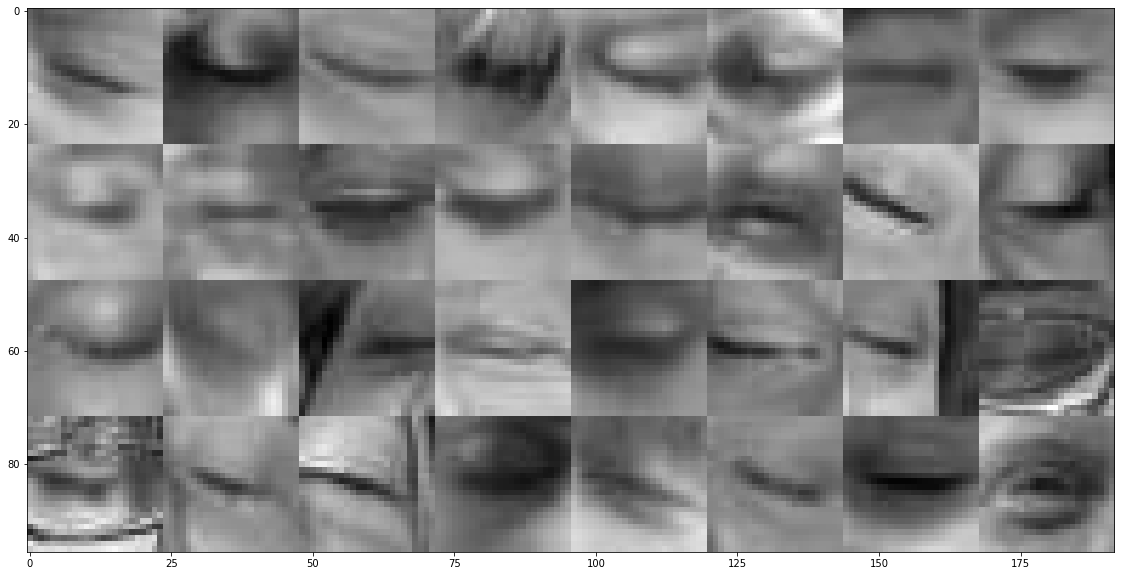

1


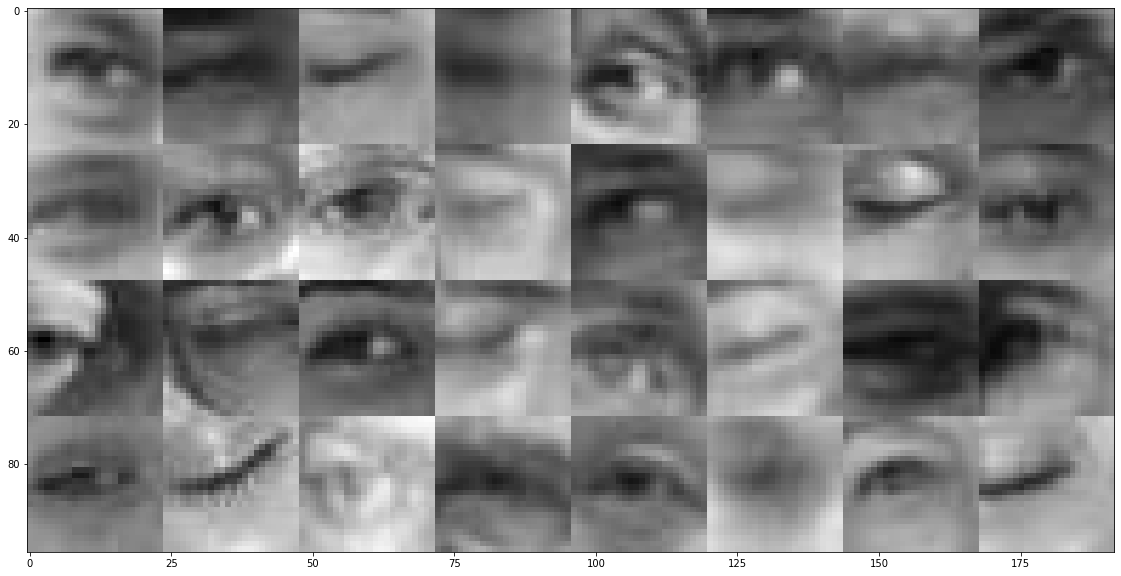

2


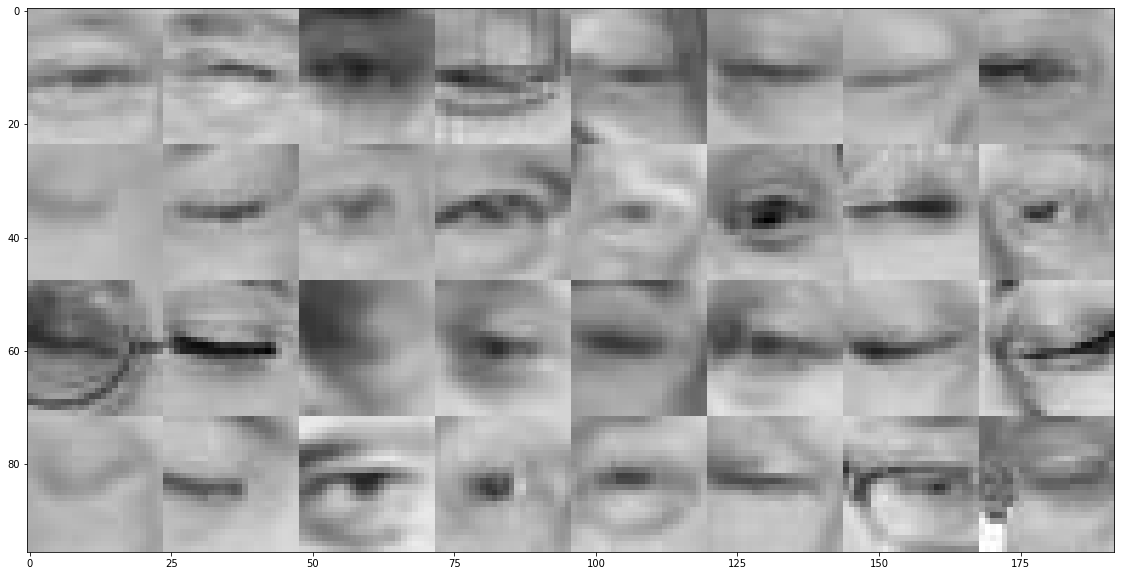

3


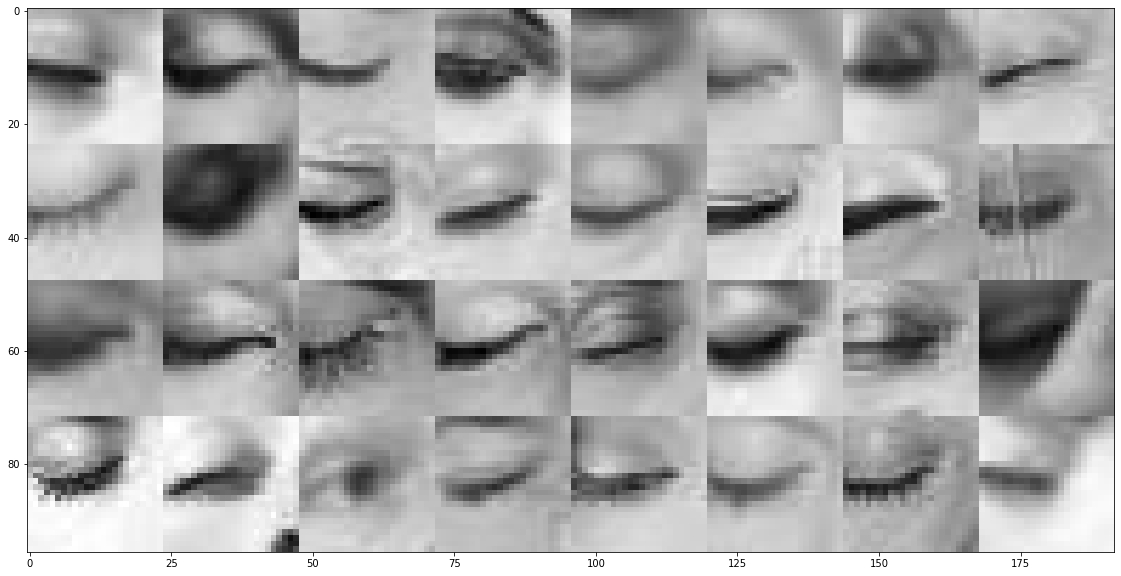

4


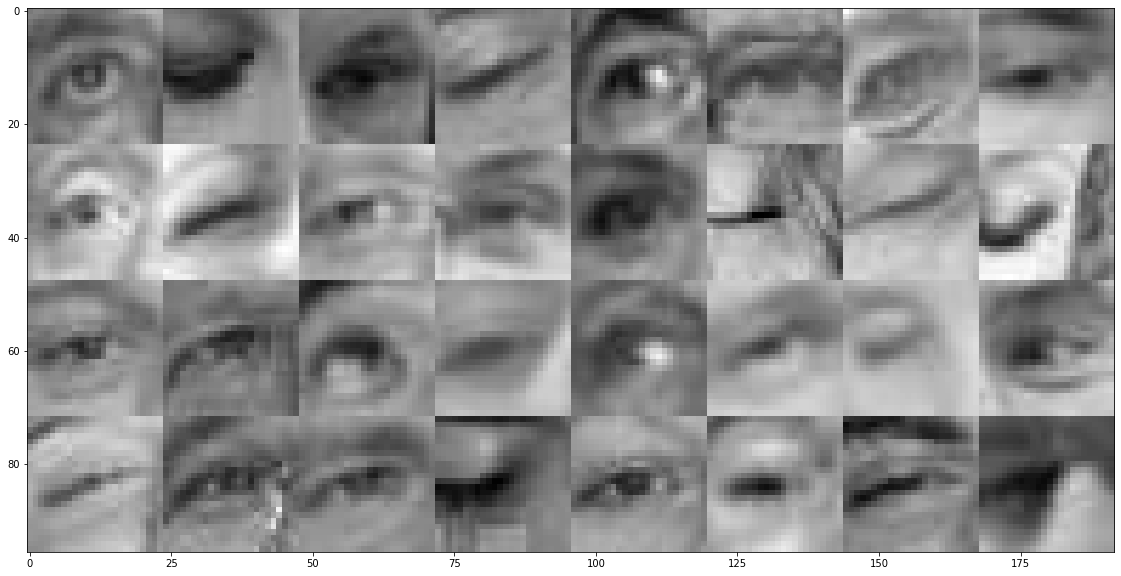

5


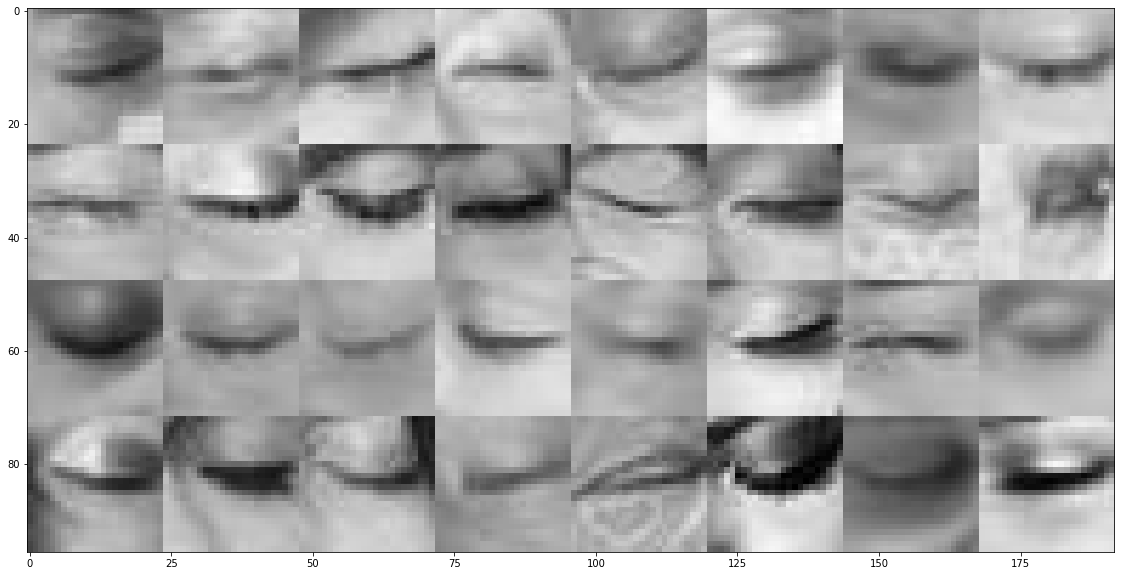

6


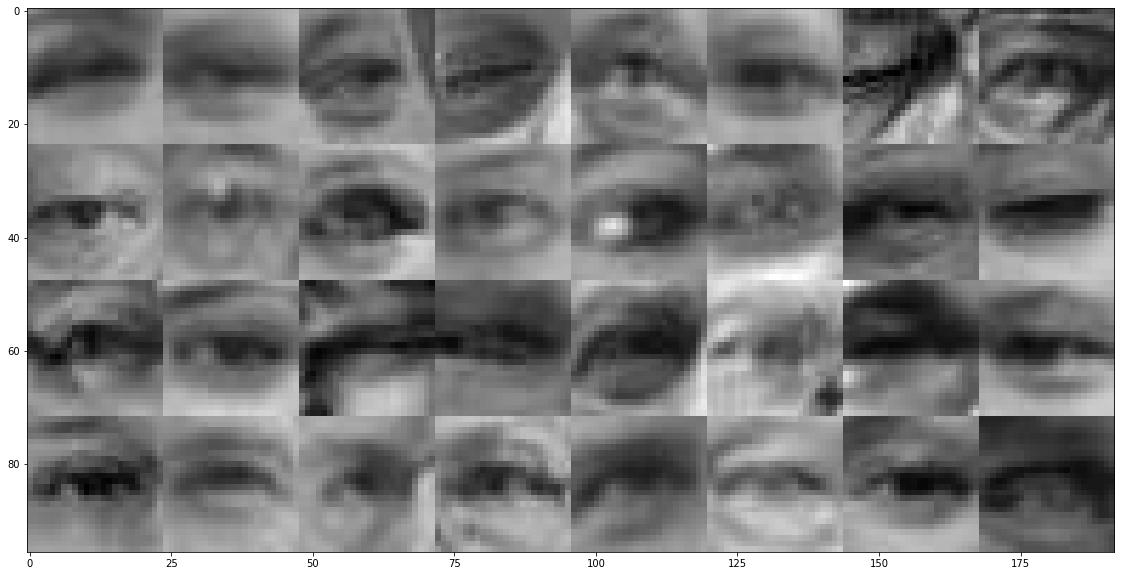

7


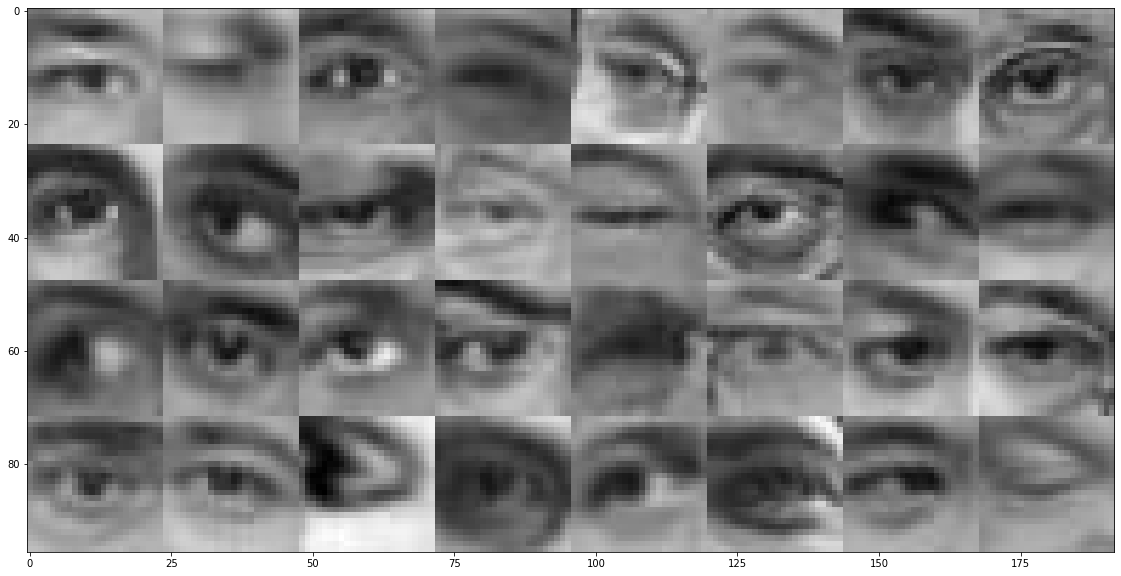

8


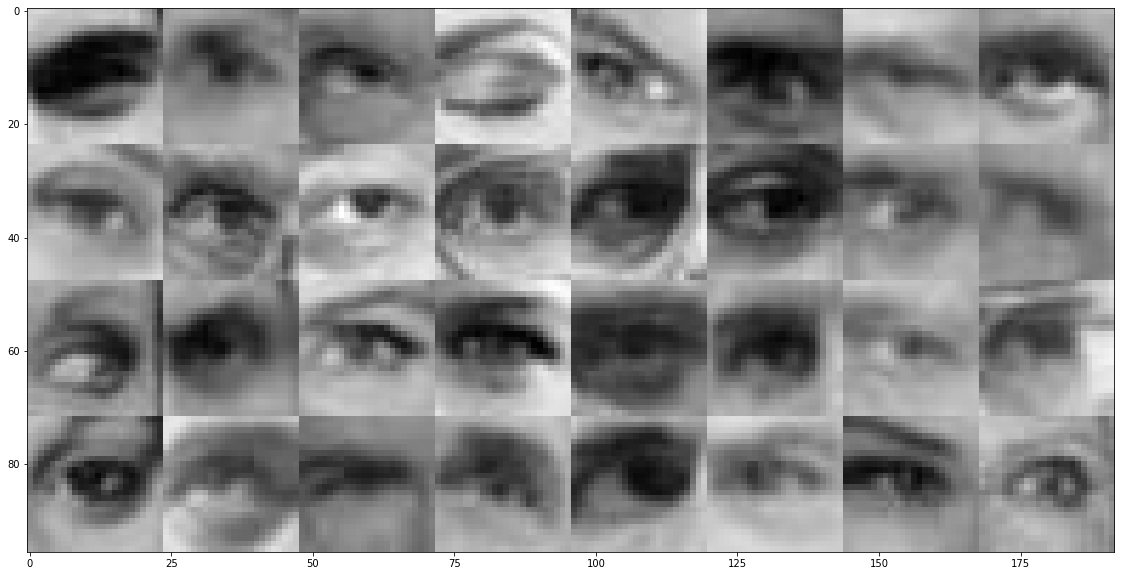

9


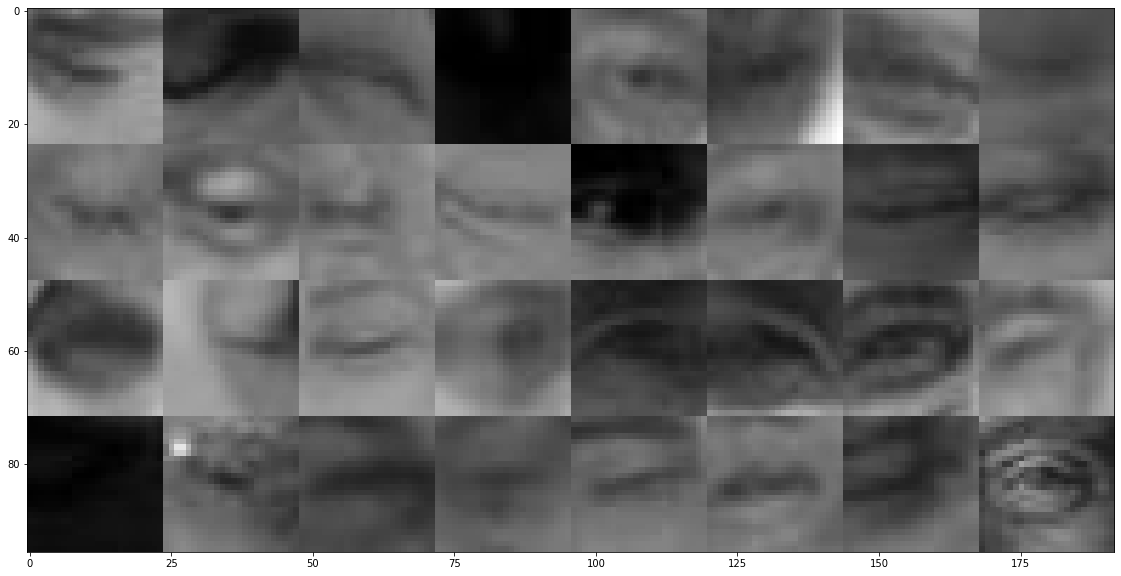

10


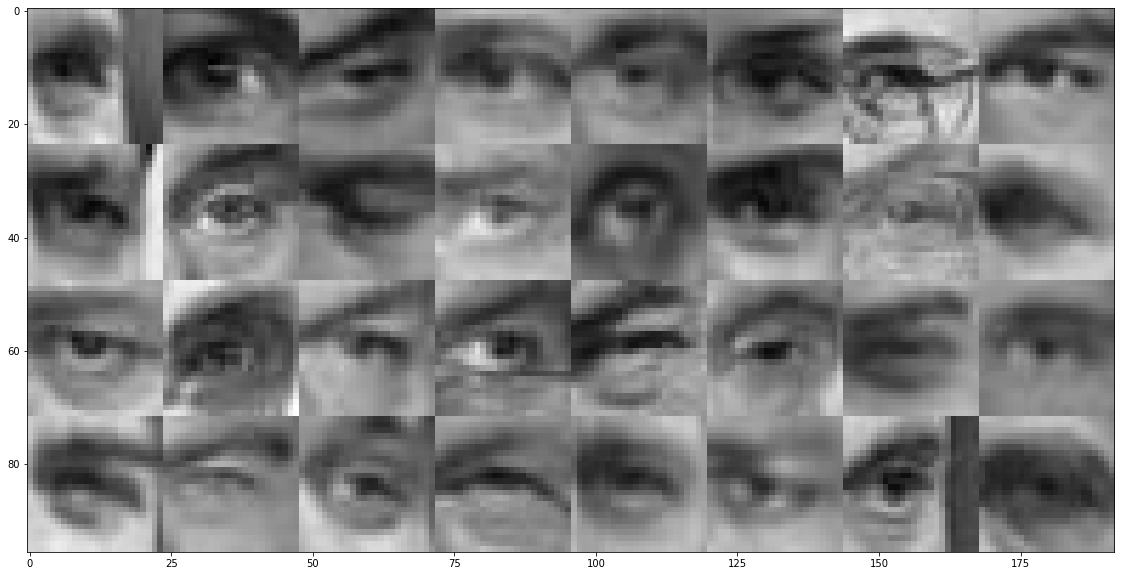

11


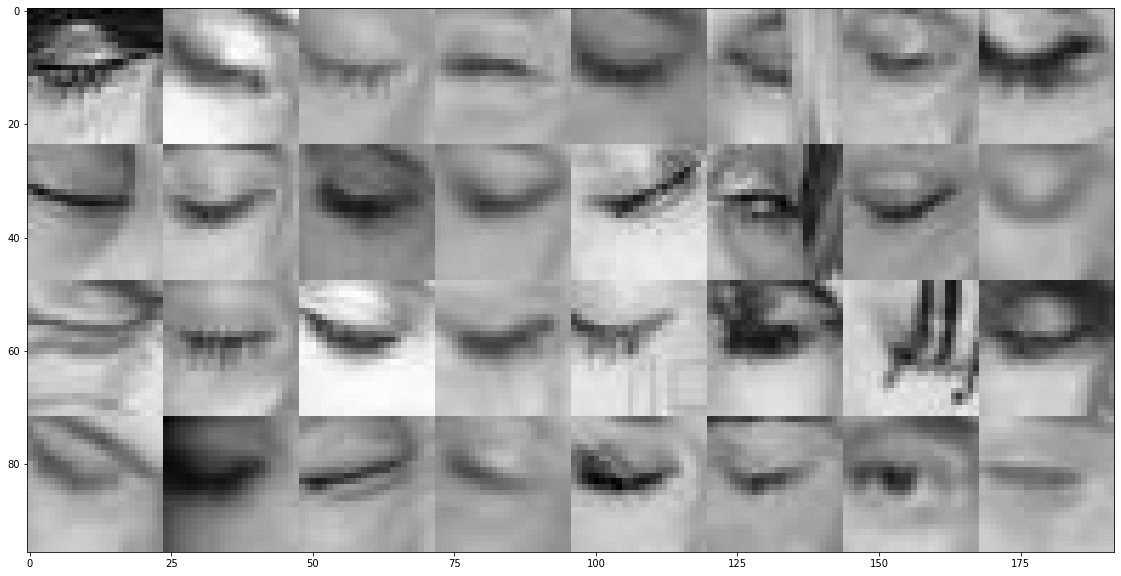

12


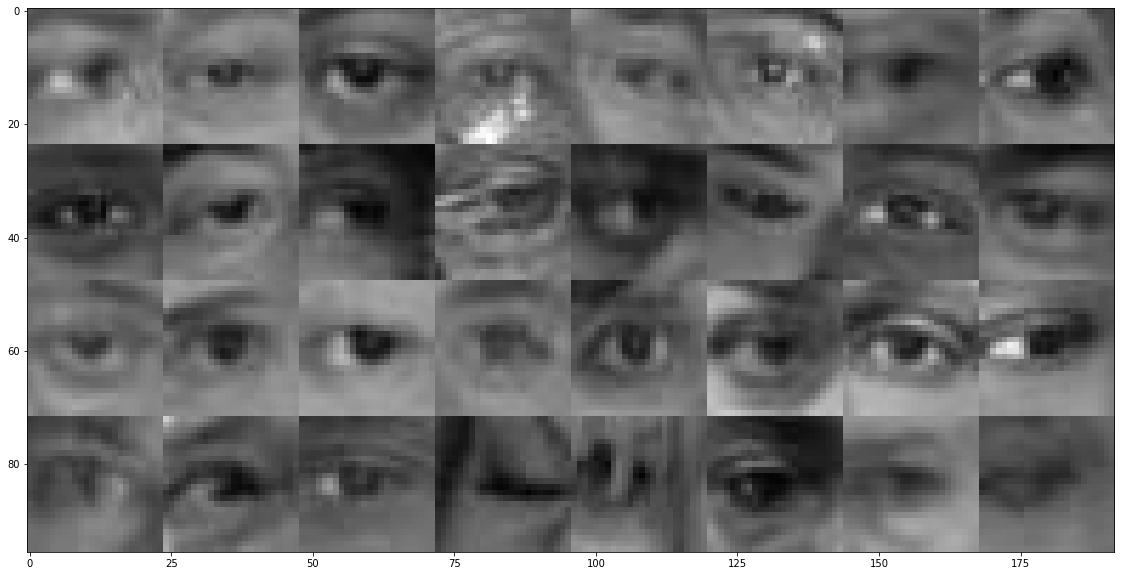

13


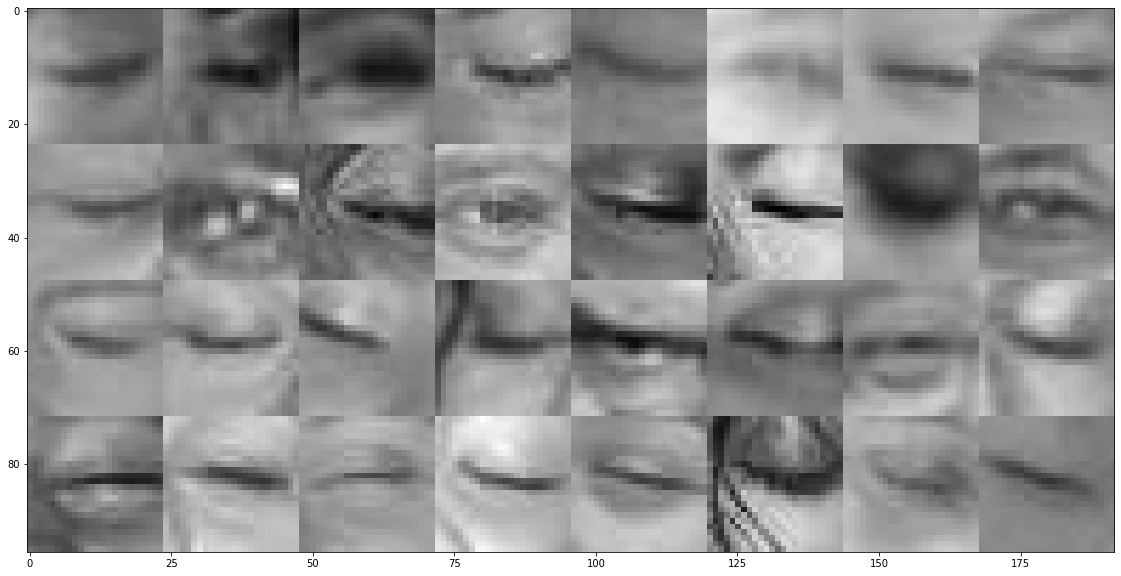

14


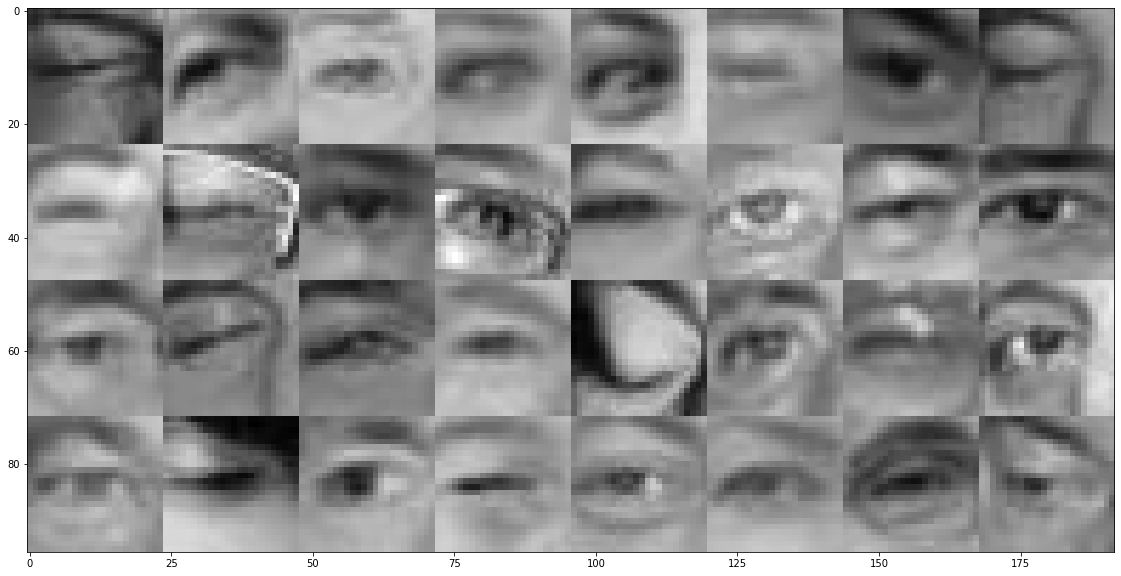

15


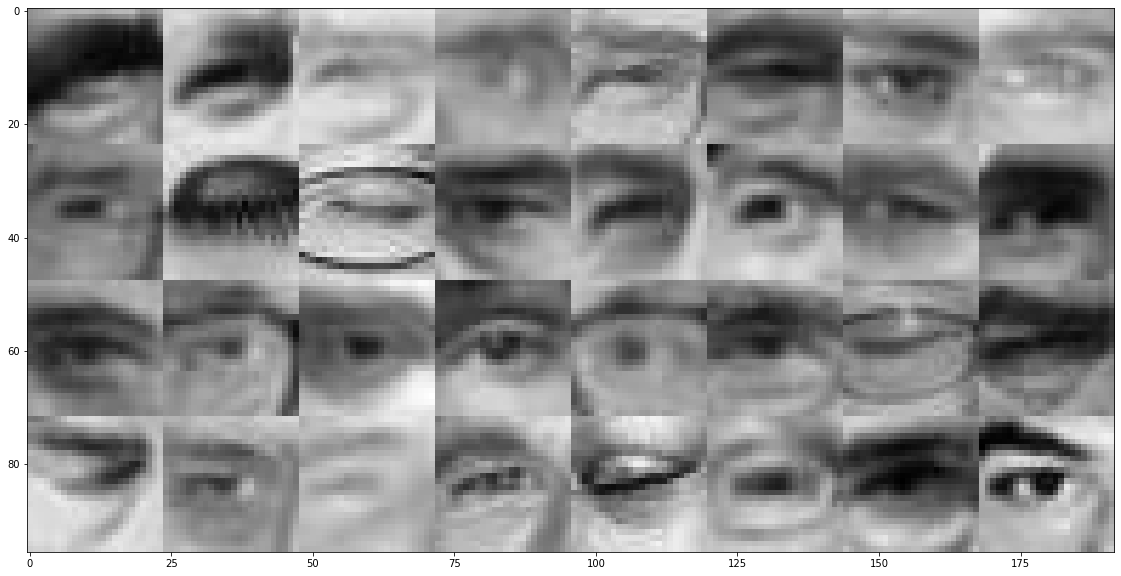

16


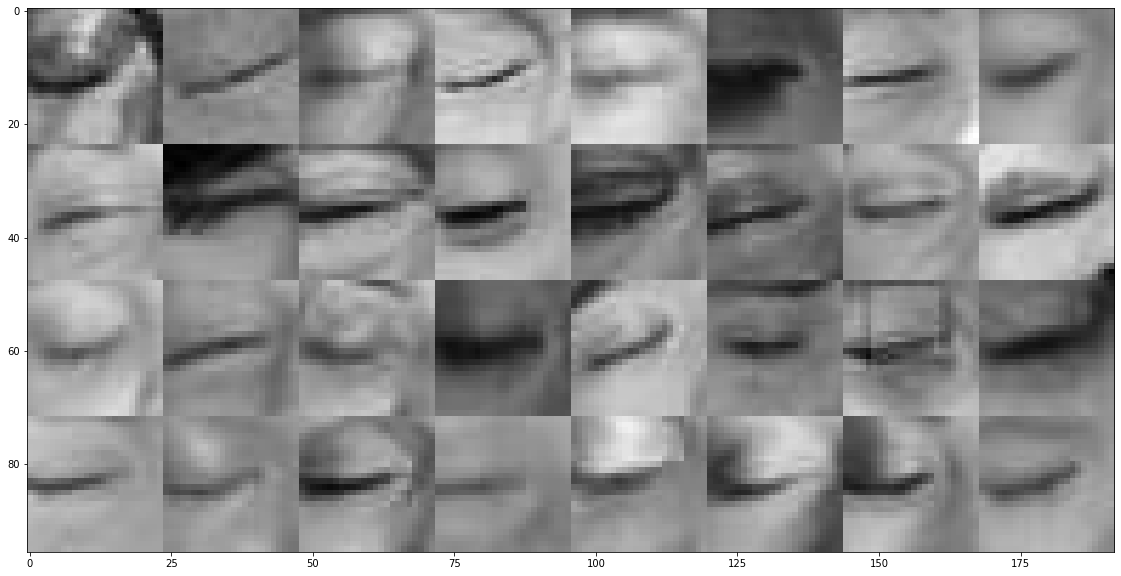

17


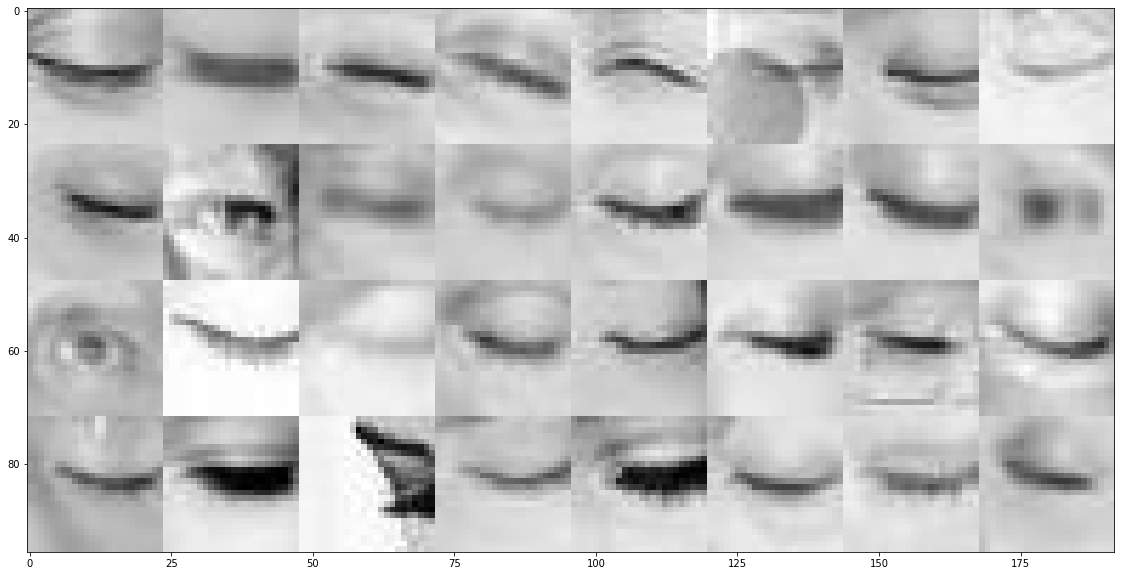

18


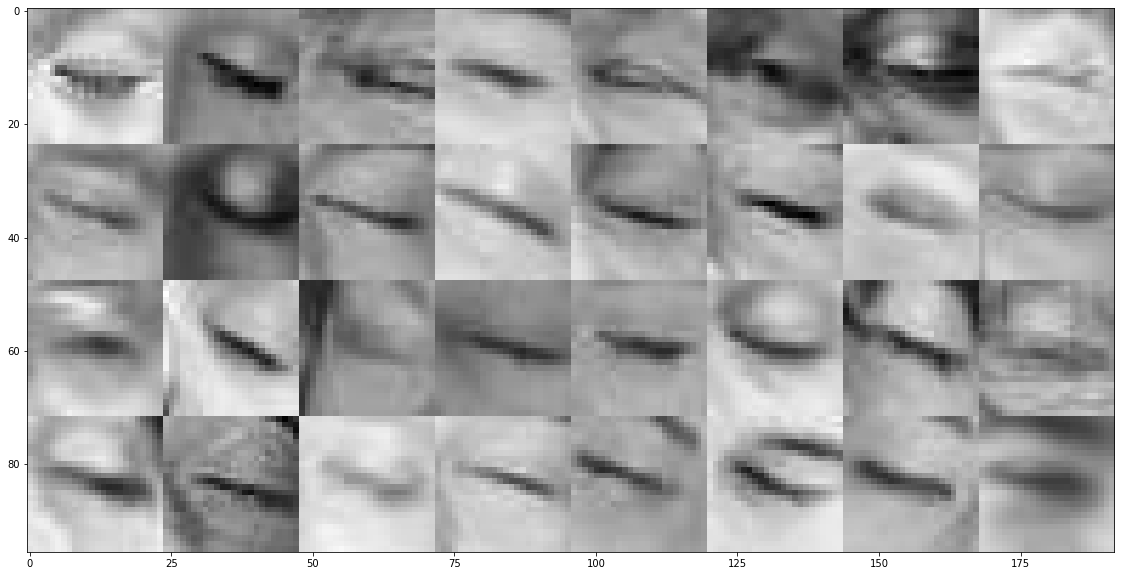

19


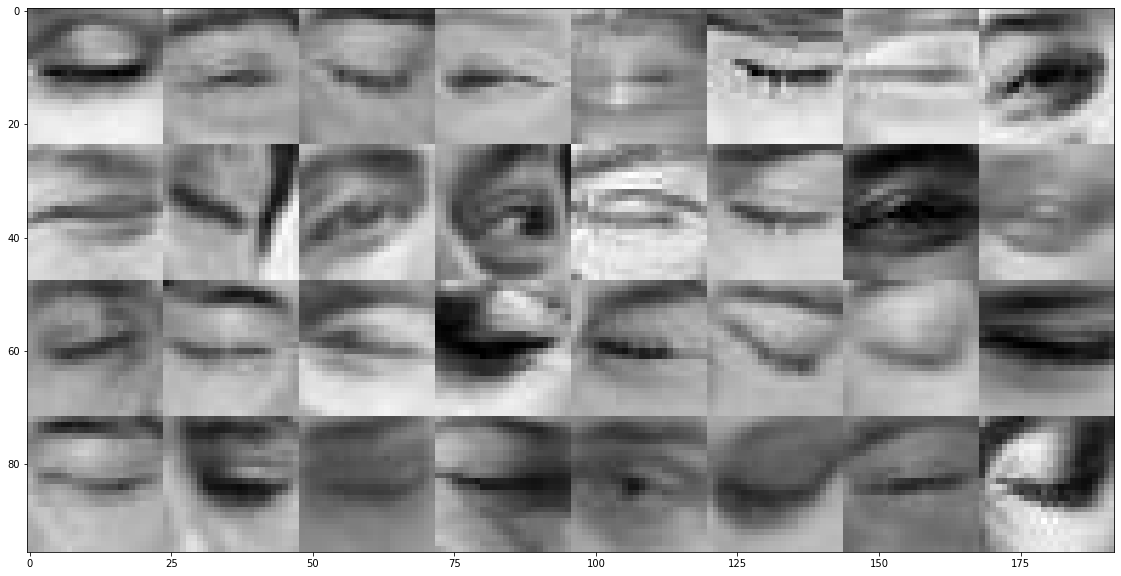

20


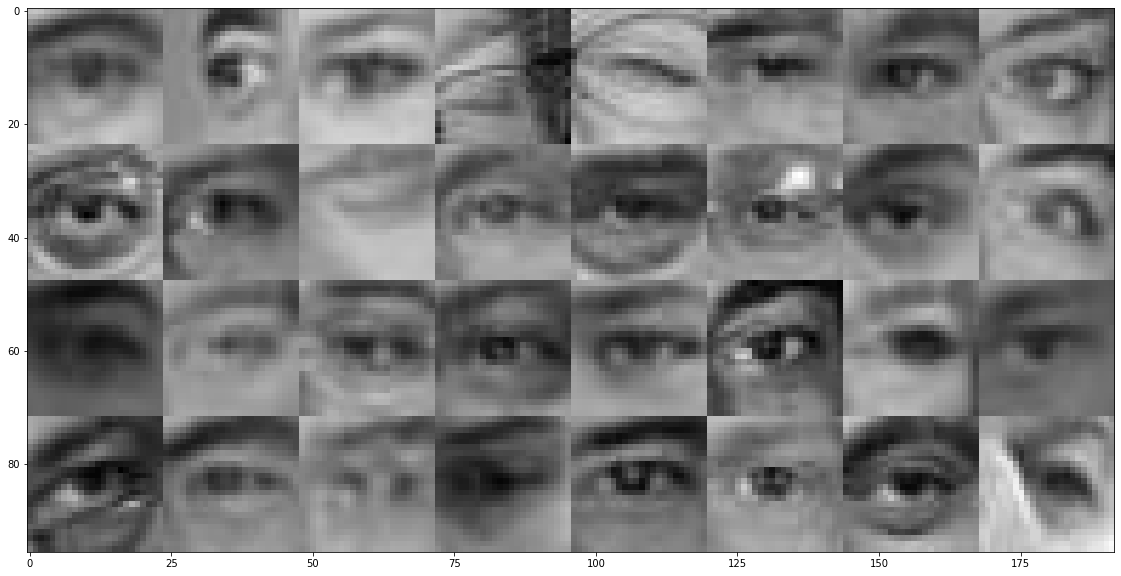

21


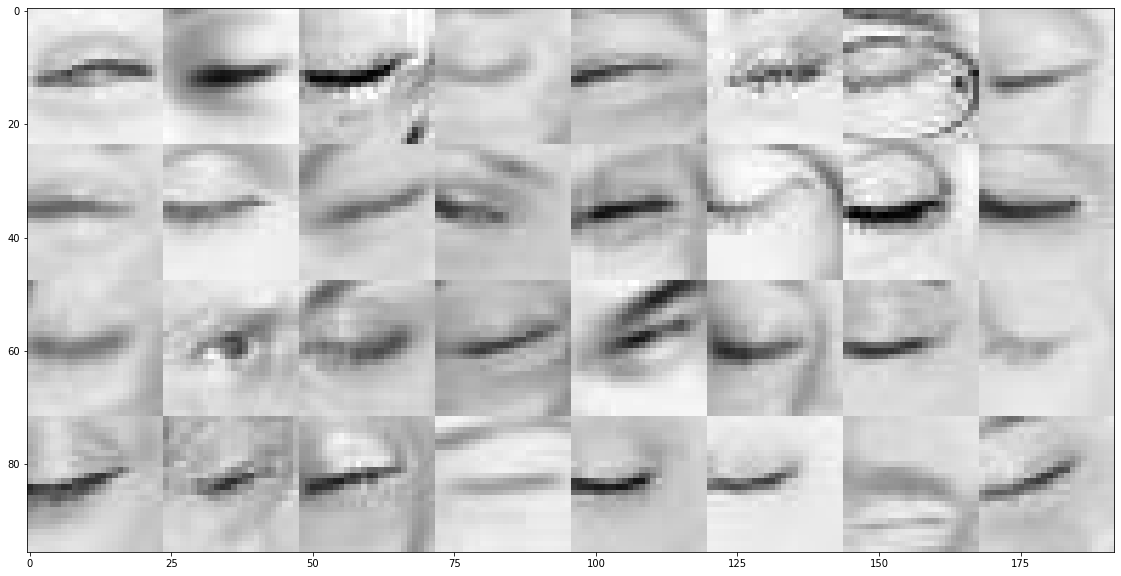

22


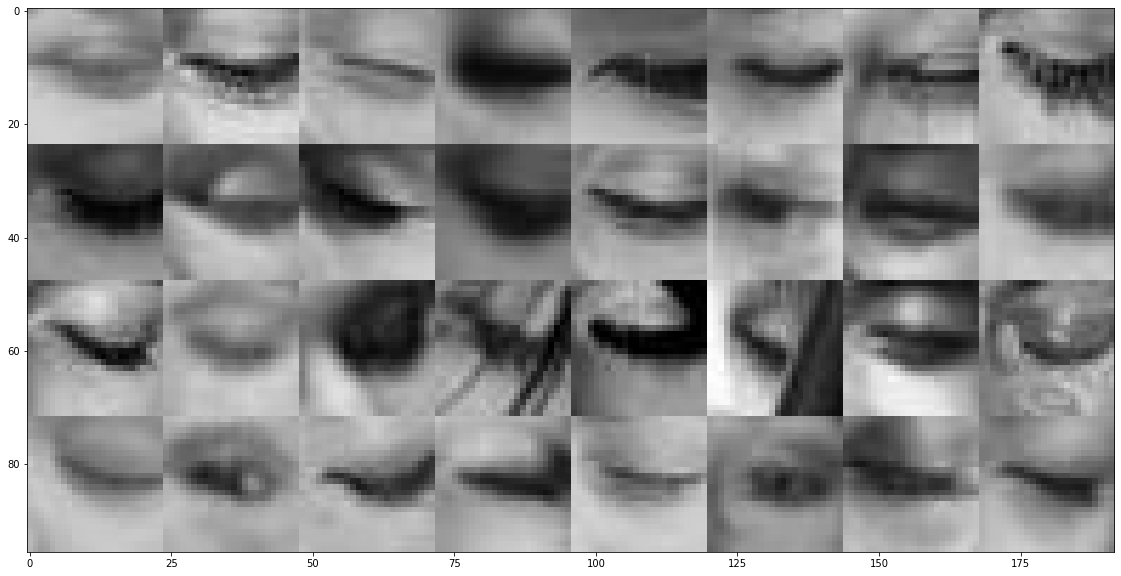

23


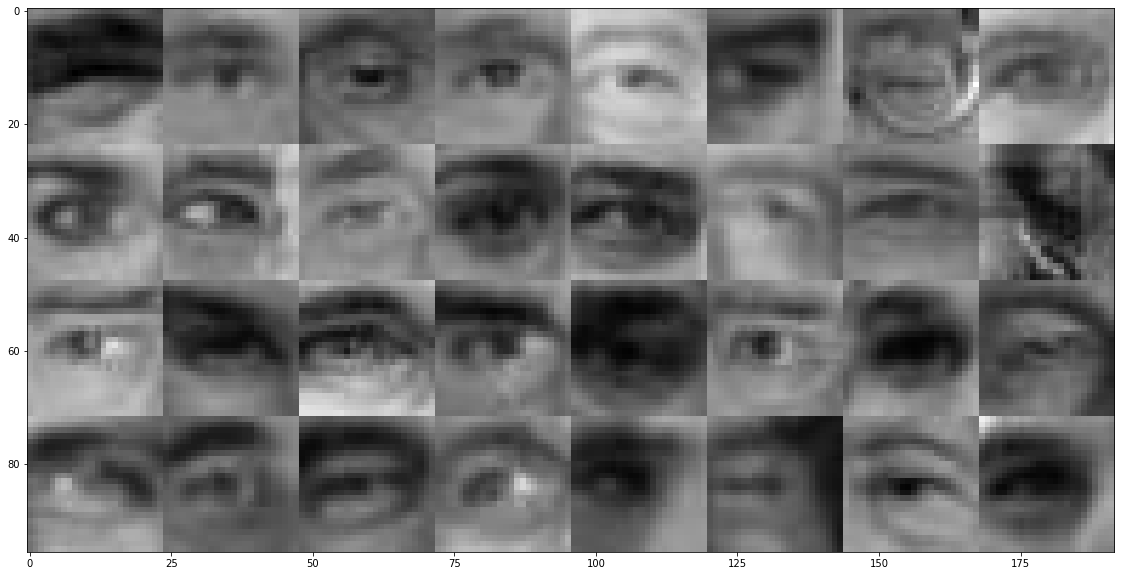

24


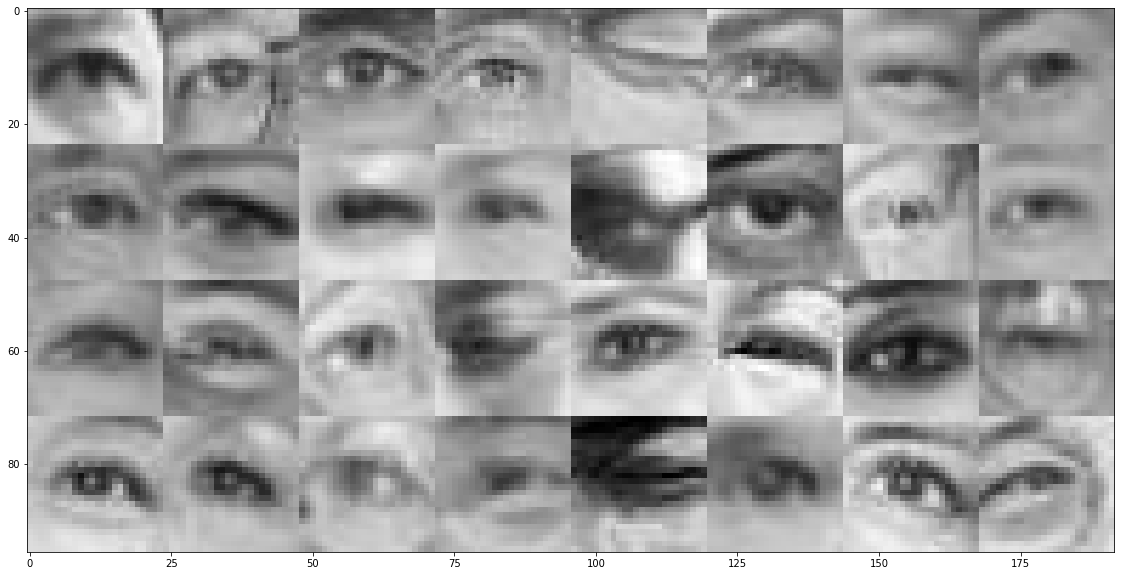

25


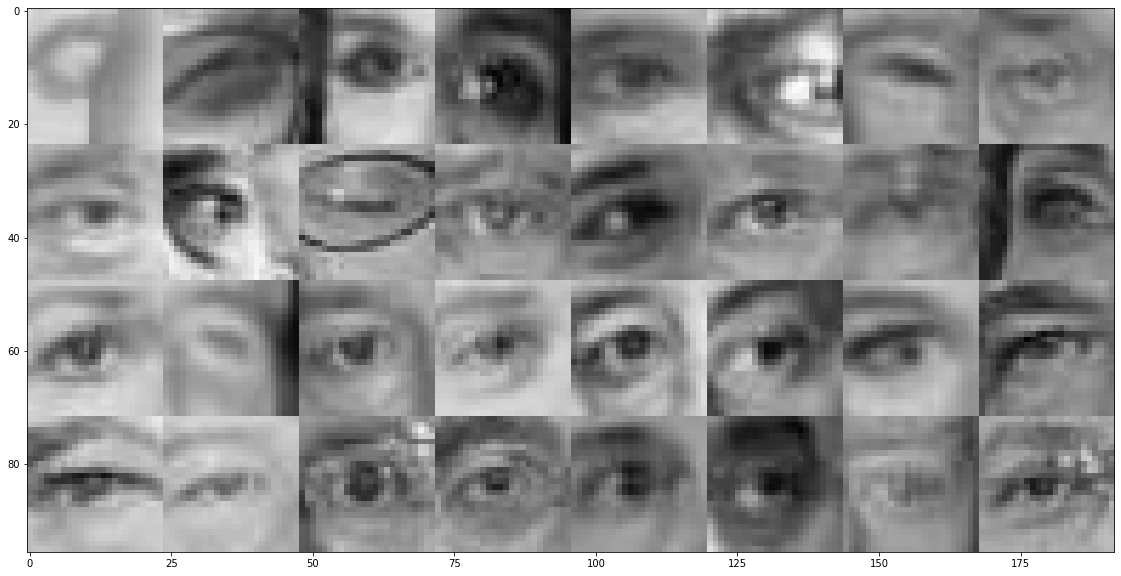

26


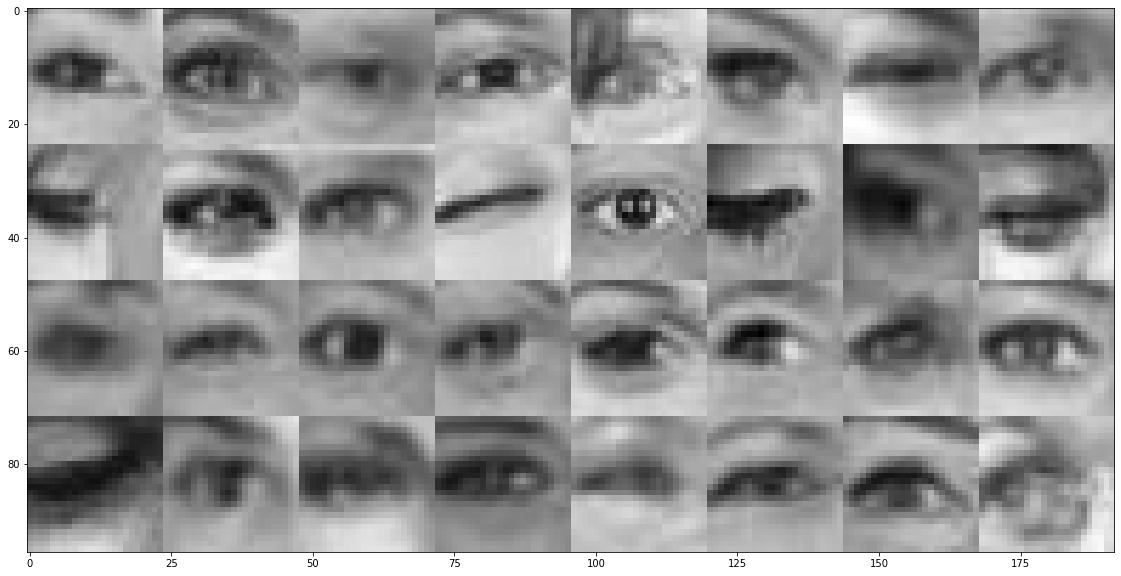

27


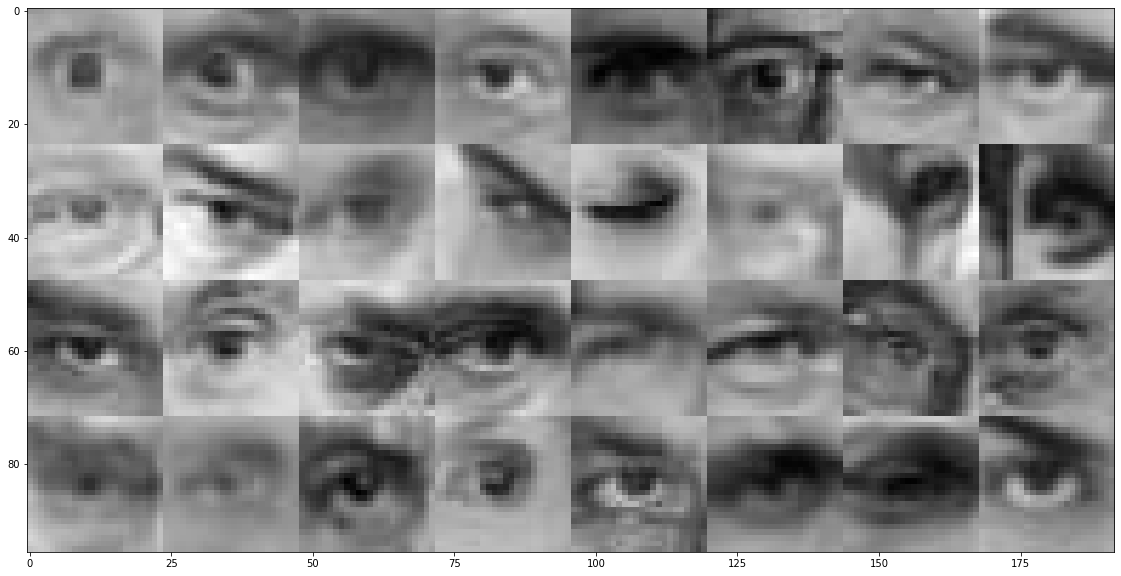

28


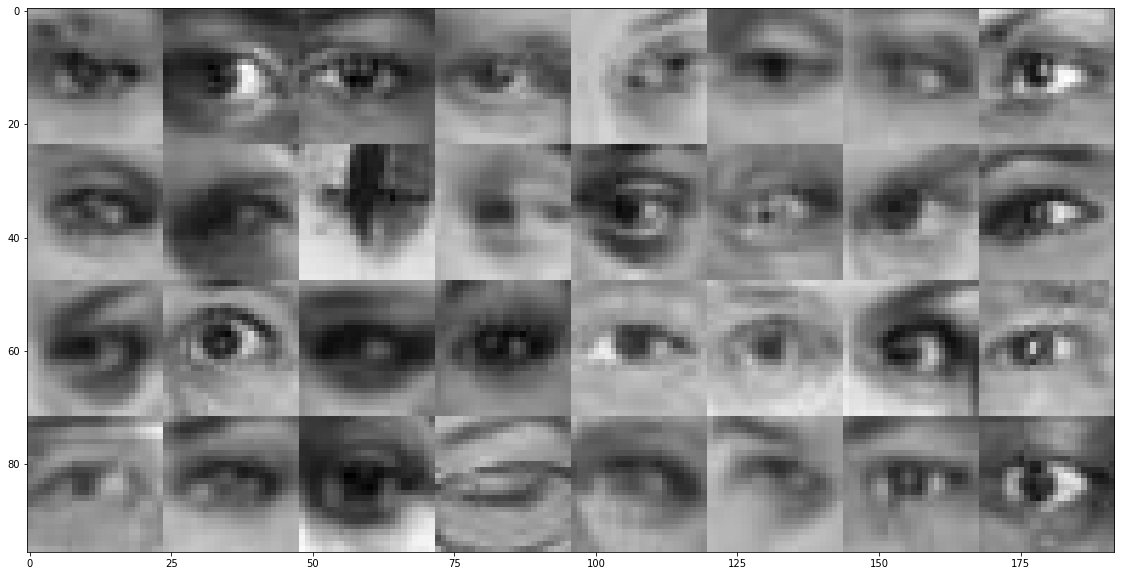

29


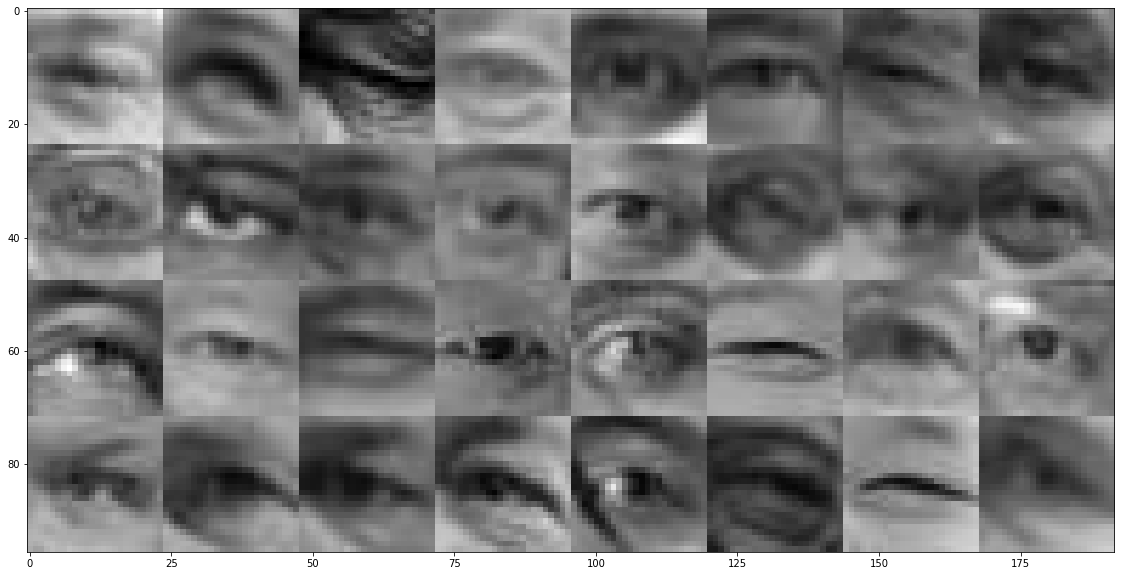

In [144]:
for j in range(30):
    i = 0
    k = 0
    for x in enumerate(train_loader_1):
        img = x[1]
    #     print(x[1].shape)
    #     img = img.view(img.size(0), -1)
        encoded, decoded = autoencoder(img)
        if y[i] == j:
            if k<8:
                if k==0:
                    numpy_h_concat_1 = img[0][3,:,:]
                else:
                    numpy_h_concat_1 = np.concatenate((img[0][3,:,:], numpy_h_concat_1), axis=1)
                k+=1
            elif k>=8 and k<16:
                if k==8:
                    numpy_h_concat_2 = img[0][3,:,:]
                else:
                    numpy_h_concat_2 = np.concatenate((img[0][3,:,:], numpy_h_concat_2), axis=1)
                k+=1
            elif k>=16 and k<24:
                if k==16:
                    numpy_h_concat_3 = img[0][3,:,:]
                else:
                    numpy_h_concat_3 = np.concatenate((img[0][3,:,:], numpy_h_concat_3), axis=1)
                k+=1
            elif k>=24:
                if k==24:
                    numpy_h_concat_4 = img[0][3,:,:]
                else:
                    numpy_h_concat_4 = np.concatenate((img[0][3,:,:], numpy_h_concat_4), axis=1)
                k+=1

        if k>=32:
    #         print(numpy_h_concat_1.shape)
    #         print(numpy_h_concat_2.shape)
    #         print(numpy_h_concat_3.shape)
    #         print(numpy_h_concat_4.shape)
            print(j)
            r = np.concatenate((numpy_h_concat_1, numpy_h_concat_2,numpy_h_concat_3,numpy_h_concat_4), axis=0)
            plt.figure(figsize=(30,10))
            plt.imshow(r.reshape(4*24,192,1), cmap = 'gray')
            plt.show()
            break
        i+=1

    #     if i>500:
    #         break

In [147]:
import pickle
filename = 'finalized_model_km.sav'
pickle.dump(model, open(filename, 'wb'))

In [148]:
l = [4,6,7,8,9,10,12,14,15,20,23,24,25,26,27,28,29]

In [149]:
checkpoint = {'model': AutoEncoder(),
              'state_dict': autoencoder.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint_cont_conv_80_new.pth')